In [1]:
import json
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score
from sklearn.preprocessing import LabelEncoder
from keras.src.utils import to_categorical


In [2]:
data_path_train = "oye_combined_augmented.json"  # Train verisi
data_path_test = "oye_combined.json"  # Test verisi

In [3]:
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)
    X = np.array(data["features"])
    y = np.array(data["labels"])
    return X, y

In [4]:
def prepare_dataset(validation_size):

    X_train, y_train = load_data(data_path_train)  # Augmented dataset
    X_test, y_test = load_data(data_path_test)  # Orijinal dataset

    # Validation set oluşturma
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    print("Unique labels train:", np.unique(y_train))
    print("Unique labels val:", np.unique(y_validation))
    print("Unique labels test:", np.unique(y_test))
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(y_train)  # Etiketleri düzelt
    y_validation = encoder.transform(y_validation)
    y_test = encoder.transform(y_test)  # Aynı dönüşümü test setine uygula

    print("after encoder")
    print("Unique labels train:", np.unique(y_train))
    print("Unique labels val:", np.unique(y_validation))
    print("Unique labels test:", np.unique(y_test))

    return X_train, X_validation, X_test, y_train, y_validation, y_test


In [5]:
def build_model(input_shape, num_classes):
    model = keras.Sequential()

    model.add(keras.layers.LSTM(256, return_sequences=True, input_shape=input_shape))
    model.add(keras.layers.LSTM(128))

    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Dense(num_classes, activation='softmax'))
    return model


In [6]:
def plot_history(history):
    fig, axs = plt.subplots(2)
    
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.show()

In [7]:
def plot_confusion_matrix(y_true, y_pred, class_labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [8]:
def calculate_f1_score(model, X_test, y_test):
    # Modelin tahminlerini al
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)  # Softmax çıktılarını sınıf indeksine çevir

    # Confusion matrix oluştur
    cm = confusion_matrix(y_test, y_pred)

    # F1-score’u hesapla
    f1_scores = f1_score(y_test, y_pred, average=None)  # Her sınıf için ayrı F1-score
    f1_scores_percent = f1_scores * 100

    # F1-score’ları yüzde olarak yazdır
    for i, score in enumerate(f1_scores_percent):
        print(f"Sınıf {i} için F1-score: %{score:.2f}")


    return cm, f1_scores

In [10]:
def plot_f1_scores(f1_scores, class_labels):
    """ F1-score'ları çubuk grafikte gösterir. """

    plt.figure(figsize=(10, 5))

    # Check if the length of f1_scores matches the length of class_labels
    if len(f1_scores) != len(class_labels):
        print("Error: Length of f1_scores and class_labels must be the same.")
        return  # Exit the function if lengths don't match

    sns.barplot(x=class_labels, y=f1_scores, palette="viridis")

    plt.xlabel("Sınıf")
    plt.ylabel("F1-Score")
    plt.title("Sınıf Bazında F1-Skorları")
    plt.ylim(0, 1)  # F1-score 0 ile 1 arasında olmalı
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

In [11]:
def calculate_recall(model, X_test, y_test):
    """ Modelin test setindeki tahminlerine göre recall hesaplar. """

    # Modelin tahminlerini al
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)  # Softmax çıktılarını sınıf indeksine çevir

    # Recall hesapla
    recall_scores = recall_score(y_test, y_pred, average=None)  # Her sınıf için ayrı recall

    recall_scores_percent = recall_scores * 100

    # Recall’ları yüzde olarak yazdır
    for i, score in enumerate(recall_scores_percent):
        print(f"Sınıf {i} için Recall: %{score:.2f}")


    return recall_scores

In [12]:
def plot_recall_scores(recall_scores):
    """ Recall skorlarını çubuk grafikte gösterir. """

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(range(len(recall_scores))), y=recall_scores, palette="magma")

    plt.xlabel("Sınıf")
    plt.ylabel("Recall")
    plt.title("Sınıf Bazında Recall Skorları")
    plt.ylim(0, 1)  # Recall 0 ile 1 arasında olmalı
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

Unique labels train: [ 0  1  2  3  4  5  7  8  9 10]
Unique labels val: [ 0  1  2  3  4  5  7  8  9 10]
Unique labels test: [ 0  1  2  3  4  5  7  8  9 10]
after encoder
Unique labels train: [0 1 2 3 4 5 6 7 8 9]
Unique labels val: [0 1 2 3 4 5 6 7 8 9]
Unique labels test: [0 1 2 3 4 5 6 7 8 9]


C:\Users\EREN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 130, 256)       │       288,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 503,690 (1.92 MB)

 Trainable params: 503,690 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
999/999 ━━━━━━━━━━━━━━━━━━━━ 145s 144ms/step - accuracy: 0.3609 - loss: 1.8203 - val_accuracy: 0.5539 - val_loss: 1.2780
Epoch 2/30
999/999 ━━━━━━━━━━━━━━━━━━━━ 147s 147ms/step - accuracy: 0.5666 - loss: 1.2602 - val_accuracy: 0.6190 - val_loss: 1.1220
Epoch 3/30
999/999 ━━━━━━━━━━━━━━━━━━━━ 204s 150ms/step - accuracy: 0.6499 - loss: 1.0388 - val_accuracy: 0.6722 - val_loss: 0.9549
Epoch 4/30
999/999 ━━━━━━━━━━━━━━━━━━━━ 166s 166ms/step - accuracy: 0.6944 - loss: 0.9042 - val_accuracy: 0.7011 - val_loss: 0.8876
Epoch 5/30
999/999 ━━━━━━━━━━━━━━━━━━━━ 168s 168ms/step - accuracy: 0.7334 - loss: 0.7954 - val_accuracy: 0.7357 - val_loss: 0.7697
Epoch 6/30
999/999 ━━━━━━━━━━━━━━━━━━━━ 157s 157ms/step - accuracy: 0.7690 - loss: 0.6917 - val_accuracy: 0.7551 - val_loss: 0.7220
Epoch 7/30
999/999 ━━━━━━━━━━━━━━━━━━━━ 165s 165ms/step - accuracy: 0.7969 - loss: 0.6211 - val_accuracy: 0.7513 - val_loss: 0.7335
Epoch 8/30
999/999 ━━━━━━━━━━━━━━━━━━━━ 148s 149ms/step - accuracy: 0.8127 -

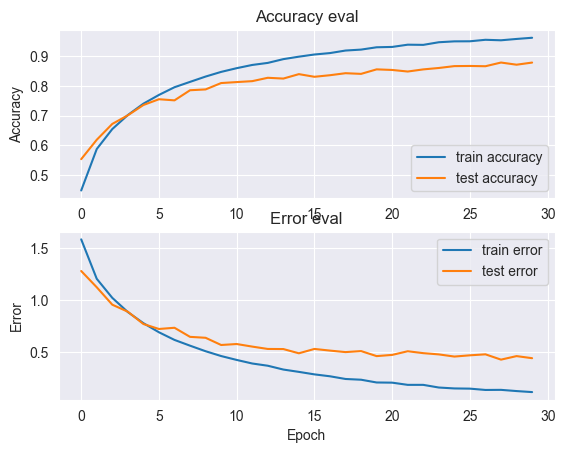

313/313 - 16s - 50ms/step - accuracy: 0.9700 - loss: 0.1018



Test Accuracy:  0.9699579477310181


In [13]:
if __name__ == "__main__":
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_dataset(0.2)


    # Assuming y_train, y_validation, y_test are your integer-encoded labels

    num_classes = len(np.unique(y_train)) # Get the number of unique classes

    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_model(input_shape, num_classes)

    # confusion matrix
    
    
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    model.summary()
    
    # train model
    history = model.fit(x=X_train, y=y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)
    #history = model.fit(x=X_train, y=y_train_one_hot, validation_data=(X_validation, y_validation_one_hot), batch_size=32, epochs=30)
    
    # plot accuracy/error for training and validation
    plot_history(history)
    
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest Accuracy: ', test_acc)
    model.save("genre_model.h5")


In [14]:
model.save('my_model.keras')

In [25]:
print("Unique labels in training set:", np.unique(y_train))
print("Unique labels in test set:", np.unique(y_test))

Unique labels in training set: [0 1 2 3 4 5 6 7 8 9]
Unique labels in test set: [0 1 2 3 4 5 6 7 8 9]


313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step


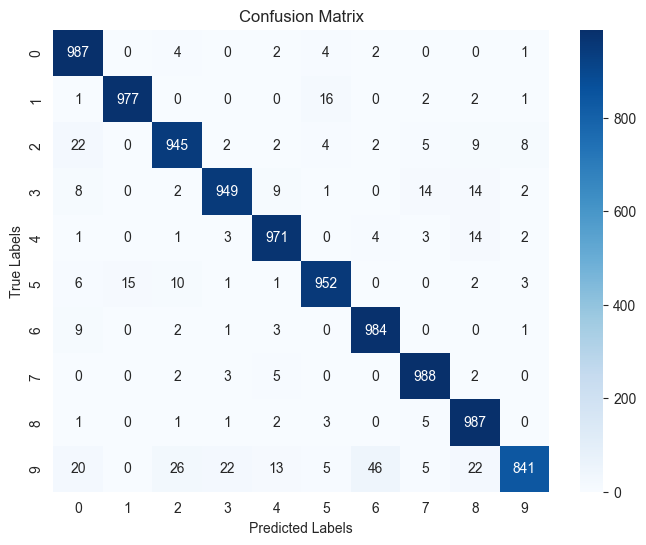

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1000
           1       0.98      0.98      0.98       999
           2       0.95      0.95      0.95       999
           3       0.97      0.95      0.96       999
           4       0.96      0.97      0.97       999
           5       0.97      0.96      0.96       990
           6       0.95      0.98      0.97      1000
           7       0.97      0.99      0.98      1000
           8       0.94      0.99      0.96      1000
           9       0.98      0.84      0.90      1000

    accuracy                           0.96      9986
   macro avg       0.96      0.96      0.96      9986
weighted avg       0.96      0.96      0.96      9986

313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step
Sınıf 0 için F1-score: %96.06
Sınıf 1 için F1-score: %98.14
Sınıf 2 için F1-score: %94.88
Sınıf 3 için F1-score: %95.81
Sınıf 4 için F1-score: %96.76
Sınıf 5 için F1-score: %96.41
Sınıf 6 için F1-sc

C:\Users\EREN\AppData\Local\Temp\ipykernel_15808\1971398374.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=f1_scores, palette="viridis")


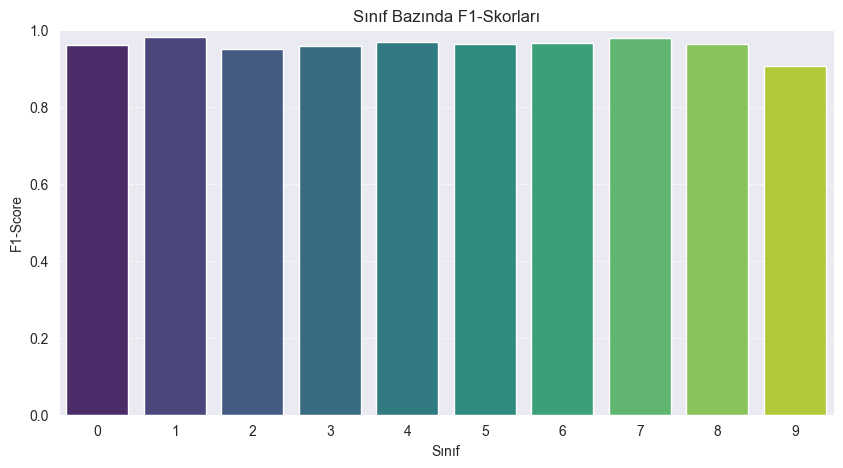

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step
Sınıf 0 için Recall: %98.70
Sınıf 1 için Recall: %97.80
Sınıf 2 için Recall: %94.59
Sınıf 3 için Recall: %94.99
Sınıf 4 için Recall: %97.20
Sınıf 5 için Recall: %96.16
Sınıf 6 için Recall: %98.40
Sınıf 7 için Recall: %98.80
Sınıf 8 için Recall: %98.70
Sınıf 9 için Recall: %84.10


C:\Users\EREN\AppData\Local\Temp\ipykernel_15808\3362363030.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(len(recall_scores))), y=recall_scores, palette="magma")


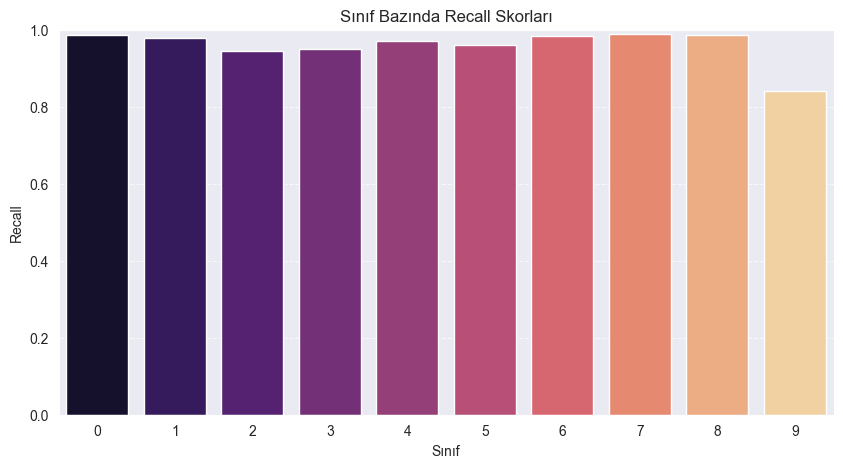

In [26]:
# Modelin tahminleri
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
class_labels = [str(i) for i in range(10)]  # 0-10 arası sınıflar varsayıldı
plot_confusion_matrix(y_test, y_pred, class_labels)

# Classification Report
print(classification_report(y_test, y_pred, target_names=class_labels))

# Test sonrası
cm, f1_scores = calculate_f1_score(model, X_test, y_test)

# F1-score plot
plot_f1_scores(f1_scores, class_labels)


# Recall hesapla
recall_scores = calculate_recall(model, X_test, y_test)

# Recall görselleştir
plot_recall_scores(recall_scores)